## Visual Intelligence: Enhancing Image Analysis for Surveillance and Investigations

Authors :
* Moses Kuria
* Eva Moisasi
* Nobert Akwir
* Nurulain Abdi
* Alice Wamuyu

# **Overview**
Visual Intelligence is an essential tool for surveillance and law enforcement agencies, providing critical information for investigations and public safety. However, compromised images, including low resolution, poor lighting, and motion blur, often limit the usability of visual evidence. To address this gap in the market, we have developed a solution using Variational Autoencoder (VAE) technology to reconstruct and enhance degraded images, providing law enforcement agencies with an advanced tool for image analysis.

## Business Understanding

The Visual Intelligence project is a cutting-edge solution that uses deep learning algorithms to reconstruct facial images from blurry or ruined images to identify suspects and solve crimes. The project's objective is to develop a robust and accurate image analysis system for law enforcement agencies to enhance their surveillance and investigations capabilities. The system will use facial image reconstruction and detection techniques to improve the ability of law enforcement agencies to solve crimes

# **Business Problem**
The current problem faced by law enforcement agencies is the difficulty in identifying suspects from blurry or ruined images. This makes it challenging for them to solve crimes quickly and efficiently. The Visual Intelligence project aims to address this problem by developing a system that can reconstruct facial features accurately, even from blurry or ruined images. This system will enhance the ability of law enforcement agencies to identify suspects and solve crimes.

## Data

For this project we used the CelebA dataset. CelebA is a large-scale face attributes dataset with more than 200,000 celebrity images, each with 40 attribute annotations. The images in the dataset are aligned and cropped, with a size of 178x218 pixels. The dataset is commonly used for tasks such as face recognition, facial attribute analysis, and face synthesis.

# **Objectives**
* The objective of our Visual
Intelligence project is to develop a
robust and accurate image analysis
system for law enforcement
agencies.
* The system will use facial image
reconstruction and detection
techniques to enhance the ability of
law enforcement agencies to solve
crimes

In [ ]:
#Importing the required libraries
import os
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import numpy as np
import cv2
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array


import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import get_file
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import UpSampling2D

In [ ]:
# Import the TensorFlow Probability (TFP) library
import tensorflow_probability as tfp
# Create aliases for the TFP distributions, layers, and bijectors modules
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
in_dir ='/content/drive/MyDrive/archive (6)/img_align_celeba (1)/img_align_celeba (1)'

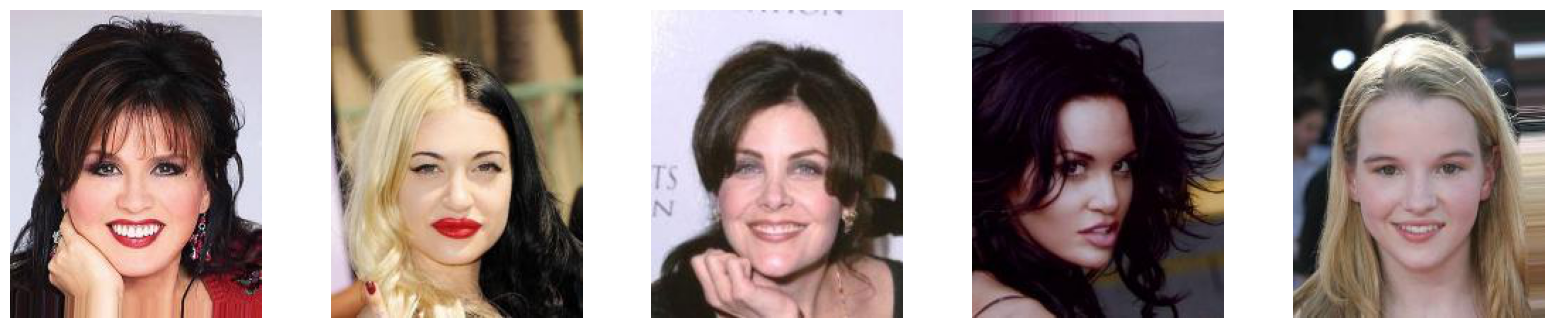

In [ ]:
in_dir ='/content/drive/MyDrive/archive (6)/img_align_celeba (1)/img_align_celeba (1)'
 # collect image paths
data_paths = []
for root, dirs, files in os.walk(in_dir):
    for file in files:
        if file.lower().endswith('.jpg'):
            data_paths.append(os.path.join(root, file))
    # Display the first 5 images in one row
    fig = plt.figure(figsize=(20, 4))
    for i in range(min(5, len(data_paths))):
        image_path = data_paths[i]
        try:
            image = Image.open(image_path)
            ax = fig.add_subplot(1, 5, i+1)
            ax.imshow(image)
            ax.axis('off')
        except Exception as e:
            print(f"Error loading image: {e}")
    plt.show()


# Data Preparation: 
* The images are preprocessed before feeding them into the model. The dataset is split into training, validation, and test sets (70% train, 30% test, and the test set is further split into 50% test and 50% validation). A batch generator function is created to yield batches of a specified size from the given sequence.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets (70% train, 30% test)
train_ds, test_ds = train_test_split(data_paths, test_size=0.3, random_state=42)

# Split the test set into test and validation sets (50% test, 50% validation)
test_ds, val_ds = train_test_split(test_ds, test_size=0.5, random_state=42)


In [ ]:
def batch_generator(sequence, batch_size):
    """Yield batches of a specified size from a given sequence."""
    while True:
        for i in range(0, len(sequence), batch_size):
            batch = sequence[i : i + batch_size]
            batch_images = []
            for image_path in batch:
                img = load_img(os.path.join('/content/drive', image_path), target_size=(64, 64))
                img = img_to_array(img) / 255.0
                batch_images.append(img)
            batch_images = np.array(batch_images)
            yield (batch_images, batch_images)  


In [ ]:
train_gen = batch_generator(train_ds, 32)
test_gen = batch_generator(test_ds, 32)
val_gen = batch_generator(val_ds, 32)

#  Define the prior distribution and the KL divergence regularizer
* prior distribution finds a compact representation (latent space) of the input images. To do this, we make an assumption about the distribution of the data in this latent space. The prior distribution is this assumption. It acts as a guide for the model to learn a meaningful representation of the data. 
* The KL (Kullback-Leibler) divergence measures the difference between the distribution learned by the encoder (the approximated distribution) and the prior distribution we defined earlier. The KL divergence regularizer is used to ensure that the approximated distribution learned by the encoder stays close to the prior distribution. By doing this, we encourage the model to learn a latent representation that aligns with our assumption (the prior distribution), which helps the model to generalize better and avoid overfitting.

In [ ]:
def get_prior(num_modes, latent_dim):
    prior = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=[1 / num_modes,] * num_modes),
        components_distribution=tfd.MultivariateNormalDiag(
            loc=tf.Variable(tf.random.normal(shape=[num_modes, latent_dim])),
            scale_diag=tfp.util.TransformedVariable(tf.Variable(tf.ones(shape=[num_modes, latent_dim])), bijector=tfb.Softplus())
        )
    )
    return prior

In [ ]:
prior = get_prior(num_modes=2, latent_dim=50)
prior

<tfp.distributions.MixtureSameFamily 'MixtureSameFamily' batch_shape=[] event_shape=[50] dtype=float32>

In [ ]:
def get_kl_regularizer(prior_distribution):
    divergence_regularizer = tfpl.KLDivergenceRegularizer(
        prior_distribution,
        use_exact_kl=False,
        weight=1.0,
        test_points_fn=lambda q: q.sample(3),
        test_points_reduce_axis=(0, 1)
    )
    return divergence_regularizer

In [ ]:
kl_regularizer = get_kl_regularizer(prior)
kl_regularizer

# **Construct the encoder and decoder networks;**
* The encoder network compresses the input data into a lower-dimensional representation, called the latent space. 
* The decoder network takes this lower-dimensional representation and reconstructs the original input data. 

In [ ]:
def get_encoder(latent_dim, kl_regularizer):
    encoder = Sequential([
        Conv2D(32, (4, 4), activation='relu', strides=2, padding='SAME', input_shape=(64, 64, 3)),
        BatchNormalization(),
        Conv2D(64, (4, 4), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        Conv2D(128, (4, 4), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        Conv2D(256, (4, 4), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        Flatten(),
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
        tfpl.MultivariateNormalTriL(latent_dim, activity_regularizer=kl_regularizer)
    ])
    return encoder

In [ ]:
encoder = get_encoder(latent_dim=50, kl_regularizer=kl_regularizer)

In [ ]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        1568      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        32832     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 batch_normalization_2 (Batc  (None, 8, 8, 128)        5

In [ ]:
def get_decoder(latent_dim):
    decoder = Sequential([
        Dense(4096, activation='relu', input_shape=(latent_dim, )),
        Reshape((4, 4, 256)),
        UpSampling2D(size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='SAME'),
        Conv2D(3, (3, 3), padding='SAME'),
        Flatten(),
        tfpl.IndependentBernoulli(event_shape=(64, 64, 3))
    ])
    return decoder

In [ ]:
decoder = get_decoder(latent_dim=50)

In [ ]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              208896    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         295040    
                                                                 
 up_sampling2d_1 (UpSampling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)       

In [ ]:
#Link the encoder and decoder together
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

In [ ]:
#Define the average reconstruction loss
def reconstruction_loss(batch_of_images, decoding_dist):
    """
    The function takes batch_of_images (Tensor containing a batch of input images to
    the encoder) and decoding_dist (output distribution of decoder after passing the 
    image batch through the encoder and decoder) as arguments.
    The function should return the scalar average expected reconstruction loss.
    """
    return -tf.reduce_mean(decoding_dist.log_prob(batch_of_images), axis=0)

In [ ]:
#Compile and fit the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=reconstruction_loss)

In [ ]:
train_steps_per_epoch = len(train_ds) // 32
val_steps_per_epoch = len(val_ds) // 32


In [ ]:
vae.fit(train_gen,
        steps_per_epoch=train_steps_per_epoch,
        validation_data=val_gen,
        validation_steps=val_steps_per_epoch,
        epochs=15)

Epoch 1/15
461/461 [==============================] - 332s 683ms/step - loss: 7045.1924 - val_loss: 6710.5806
Epoch 2/15
461/461 [==============================] - 46s 99ms/step - loss: 6651.4160 - val_loss: 6563.5234
Epoch 3/15
461/461 [==============================] - 50s 110ms/step - loss: 6532.4482 - val_loss: 6459.3472
Epoch 4/15
461/461 [==============================] - 46s 100ms/step - loss: 6463.5981 - val_loss: 6429.3340
Epoch 5/15
461/461 [==============================] - 49s 106ms/step - loss: 6419.1519 - val_loss: 6370.5464
Epoch 6/15
461/461 [==============================] - 49s 107ms/step - loss: 6380.0063 - val_loss: 6350.1851
Epoch 7/15
461/461 [==============================] - 46s 100ms/step - loss: 6351.3677 - val_loss: 6333.9751
Epoch 8/15
461/461 [==============================] - 45s 97ms/step - loss: 6324.8989 - val_loss: 6330.6162
Epoch 9/15
461/461 [==============================] - 50s 108ms/step - loss: 6304.4795 - val_loss: 6302.4814
Epoch 10/15
461/461 

In [ ]:
test_steps = len(test_ds) // 32
test_loss = vae.evaluate(test_gen, steps=test_steps)
print("Test loss: {}".format(test_loss))

98/98 [==============================] - 8s 79ms/step - loss: 6229.8867
Test loss: 6229.88671875


### Compute reconstructions of test images

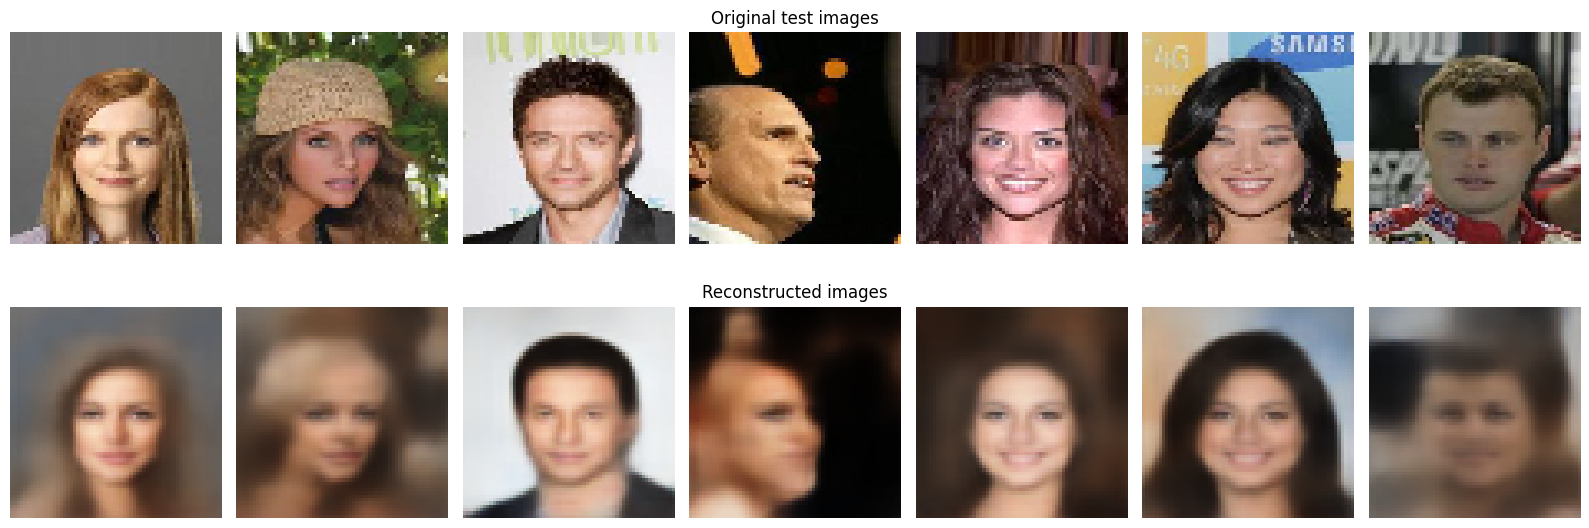

In [ ]:
def reconstruct(encoder, decoder, batch_of_images):
    """
    The function takes the encoder, decoder, and batch_of_images as inputs, which
    should be used to compute the reconstructions.
    The function should then return the reconstructions Tensor.
    """
    approx_posterior = encoder(batch_of_images)
    decoding_dist = decoder(approx_posterior.mean())
    return decoding_dist.mean()

n_reconstructions = 7

# Get a batch of test images
test_images, _ = next(test_gen)
example_images = test_images[:n_reconstructions]

reconstructions = reconstruct(encoder, decoder, example_images).numpy()

f, axs = plt.subplots(2, n_reconstructions, figsize=(16, 6))
axs[0, n_reconstructions // 2].set_title("Original test images")
axs[1, n_reconstructions // 2].set_title("Reconstructed images")

for j in range(n_reconstructions):
    axs[0, j].imshow(example_images[j])
    axs[1, j].imshow(reconstructions[j])
    axs[0, j].axis('off')
    axs[1, j].axis('off')

plt.tight_layout()


The code below modifies the code to increase the latent space dimensions to see if it improves the model's performance, I've changed the latent dimension from 50 to 100, and increased the number of training epochs from 15 to 20.


In [ ]:
 latent_dim = 100  # Increase the latent space dimensions from 50 to 100

prior = get_prior(num_modes=2, latent_dim=latent_dim)
prior

kl_regularizer = get_kl_regularizer(prior)
kl_regularizer

encoder = get_encoder(latent_dim=latent_dim, kl_regularizer=kl_regularizer)
encoder.summary()

decoder = get_decoder(latent_dim=latent_dim)
decoder.summary()

# Link the encoder and decoder together
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

# Compile and fit the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=reconstruction_loss)

train_steps_per_epoch = len(train_ds) // 32
val_steps_per_epoch = len(val_ds) // 32

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        1568      
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 64)        32832     
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 128)         131200    
                                                                 
 batch_normalization_6 (Batc  (None, 8, 8, 128)       

In [ ]:
vae.fit(train_gen,
        steps_per_epoch=train_steps_per_epoch,
        validation_data=val_gen,
        validation_steps=val_steps_per_epoch,
        epochs=20)

Epoch 1/20
461/461 [==============================] - 60s 109ms/step - loss: 7213.9097 - val_loss: 6815.6870
Epoch 2/20
461/461 [==============================] - 48s 104ms/step - loss: 6720.8311 - val_loss: 6653.3394
Epoch 3/20
461/461 [==============================] - 48s 105ms/step - loss: 6568.6235 - val_loss: 6530.8350
Epoch 4/20
461/461 [==============================] - 45s 98ms/step - loss: 6480.6445 - val_loss: 6465.3833
Epoch 5/20
461/461 [==============================] - 49s 106ms/step - loss: 6422.7202 - val_loss: 6379.3018
Epoch 6/20
461/461 [==============================] - 46s 100ms/step - loss: 6378.2715 - val_loss: 6347.0332
Epoch 7/20
461/461 [==============================] - 49s 106ms/step - loss: 6344.3662 - val_loss: 6315.0308
Epoch 8/20
461/461 [==============================] - 45s 97ms/step - loss: 6313.5493 - val_loss: 6295.2500
Epoch 9/20
461/461 [==============================] - 45s 97ms/step - loss: 6289.6719 - val_loss: 6287.4058
Epoch 10/20
461/461 [=

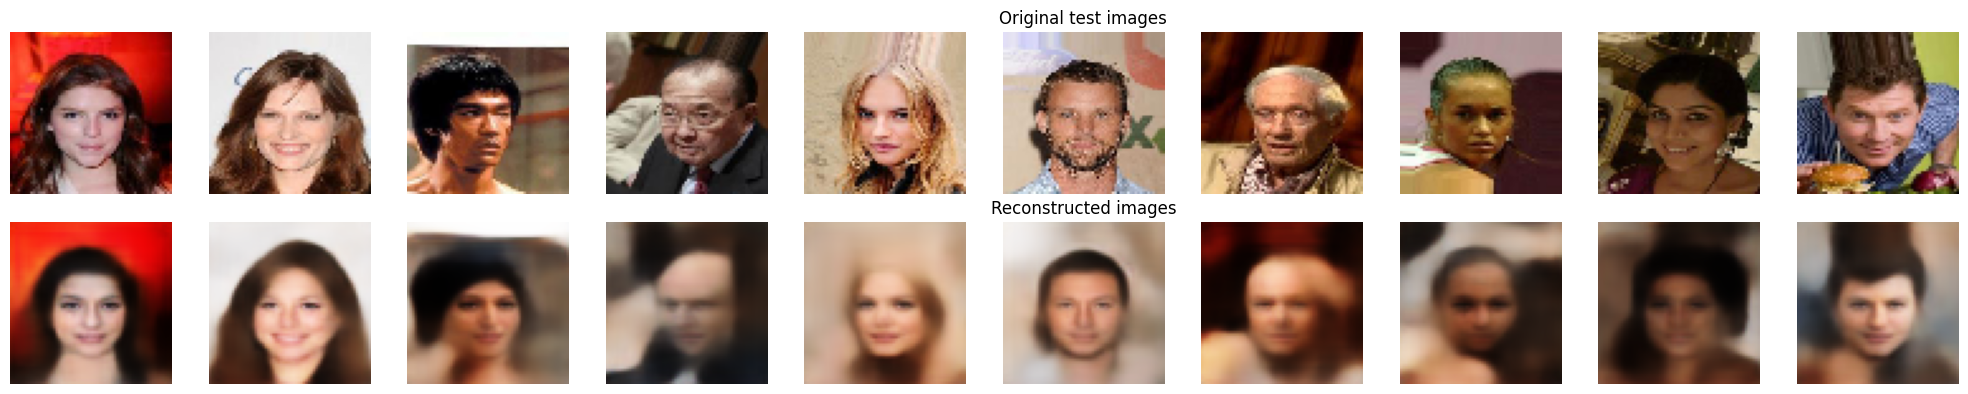

In [ ]:
def reconstruct(encoder, decoder, batch_of_images):
    """
    The function takes the encoder, decoder, and batch_of_images as inputs, which
    should be used to compute the reconstructions.
    The function should then return the reconstructions Tensor.
    """
    approx_posterior = encoder(batch_of_images)
    decoding_dist = decoder(approx_posterior)
    return decoding_dist.mean()

n_reconstructions = 10

# Get a batch of validation images
val_images, _ = next(val_gen)
example_images = val_images[:n_reconstructions]

reconstructions = reconstruct(encoder, decoder, example_images)

# Convert the tensor to a NumPy array
reconstructions_np = reconstructions.numpy()

f, axs = plt.subplots(2, n_reconstructions, figsize=(20, 4))
axs[0, n_reconstructions // 2].set_title("Original test images")
axs[1, n_reconstructions // 2].set_title("Reconstructed images")

for j in range(n_reconstructions):
    axs[0, j].imshow(np.squeeze(example_images[j]), cmap='gray')
    axs[1, j].imshow(np.squeeze(reconstructions_np[j]), cmap='gray')
    axs[0, j].axis('off')
    axs[1, j].axis('off')

plt.tight_layout()
plt.show()



# **Evaluation**
* Upon visually inspecting the reconstructed images, we obtain a qualitative assessment of the VAE's performance. Comparing the original images to their corresponding reconstructions allows us to gauge the VAE's ability to capture crucial features and details within the input images. Our VAE model generated reconstructions that were strikingly similar to the original images in aspects such as facial features, color, and overall structure. This comparison highlights the model's proficiency in learning significant representations of the data, serving as a foundation for future model optimizations and enhancements.

## Model 2:  Single Image Super-Resolution Using Super-Resolution Generative Adversarial Network(SRGAN)

SRGAN is a deep learning model used for image super-resolution, which generates high-resolution images from low-resolution ones. It consists of a generator and discriminator, where the generator uses a deep residual network (ResNet) to generate high-quality images, while the discriminator is responsible for distinguishing between real and generated high-resolution images. The generator is trained using a content loss and adversarial loss, while the discriminator is trained to classify images as real or generated. SRGAN has many applications in various fields, but requires a large amount of high-resolution image data for training.

Original paper: https://arxiv.org/pdf/1609.04802.pdf


All images resized to 128x128 to represent HR(High resolution) and 32x32 to represent LR(Low resolution)

In [ ]:
#importing the libraries
import tensorflow as tf
import numpy as np
import os
import cv2
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import get_file
import zipfile
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm
from keras.applications import VGG19


In [ ]:
#loading the data from its source

base_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip"
file_name = 'celeba.zip'

path = get_file(file_name, base_url, extract = False)

with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('/content/')


data_dir = '/content/img_align_celeba/'

1443490838/1443490838 [==============================] - 86s 0us/step


We define the lower resolution size to be 32 by 32. This is a good size to start from as our case scenario is CCTV image superresolution. In the instance of zooming in to a single image to obtain a face, the relevant area of the image may only be 32 by 32. In our model, we will only resize it to 128 by 128, as these are the limits of Google colab. Beyond that, the session will crash.

We start by defining a function to load images into memory. This function will resize the images to 128 by 128 as the original images in CelebA dataset are 178 by 218 pixels. These will serve as our High Resolution dataset.

Subsequently, we define a function to create our low resolution dataset. To simulate how a CCTV images would look, we also downsampled our image using Bicubic interpolation as we resized the image to 32 by 32.

In [ ]:
# Define the size of the low-resolution images
lr_size = (32, 32)
hr_size = (128, 128)


# Load the CelebA dataset
def load_celeba(num_images=5000):
    # Define the path to the CelebA images directory
    img_dir = data_dir
    
    # Load the filenames of the images
    img_filenames = os.listdir(img_dir)[:num_images]
    
    # Sort the filenames alphabetically
    img_filenames.sort()
    
    # Load the images
    images = []
    for filename in img_filenames:
        img_path = os.path.join(img_dir, filename)
        img = tf.keras.preprocessing.image.load_img(img_path)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = tf.image.resize(img, hr_size)
        images.append(img)
        
    
    return images


# Create a dataset of low-resolution images by downscaling the high-resolution images,
# adding noise, and applying a blur filter
def create_lr_dataset(hr_images, num_images=5000):
    lr_images = []
    for img in hr_images[:num_images]:
        # Downscale the high-resolution image using bicubic interpolation
        lr_img = tf.image.resize(img, lr_size, method='bicubic')
        img = np.array(lr_img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert color channels from RGB to BGR
      
        lr_images.append(lr_img)
        
    return lr_images

    # Load the CelebA dataset and create a dataset of low-resolution images
hr_images = load_celeba()
lr_images = create_lr_dataset(hr_images)


In a Generative Adversarial Network (GAN), the generator is typically composed of several building blocks that are designed to create high-quality images. Two important blocks in a GAN generator are the residual (res) block and the upscale block.

A res block is a building block that allows the generator to learn residual functions to improve image quality. It consists of a series of convolutional layers followed by batch normalization and activation functions. The output of the res block is the sum of the input to the block and the output of the final convolutional layer.

An upscale block is a building block that is used to increase the spatial resolution of the images generated by the generator. It typically consists of a convolutional layer followed by an up-sampling operation, such as nearest-neighbor or bilinear interpolation. The output of the upscale block is typically a larger image with finer details.

In [ ]:
#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

We start by defining a generator model that takes as input an image tensor (gen_ip) and a parameter num_res_block that determines the number of residual blocks used in the generator.

The generator starts by applying a 9x9 convolution with 64 filters to the input image, followed by a PReLU activation function. The output of this layer is then stored in a temporary variable "temp".

The generator then applies the specified number of residual blocks (num_res_block) by calling the "res_block" function in a loop. This allows the generator to learn residual functions to improve image quality.

After the residual blocks, the generator applies another 3x3 convolution with 64 filters followed by batch normalization with a momentum value of 0.5. The output of this layer is added to the temporary variable "temp" to create a skip connection that allows the generator to preserve low-level features.

The generator then applies two upscaling blocks using the "upscale_block" function, which increases the spatial resolution of the image. The output of the last upscaling block is a high-resolution image tensor with three channels, which is obtained by applying a final 9x9 convolutional layer with three filters (corresponding to the three color channels).

We define a discriminator block that is used to construct the discriminator network. The discriminator is responsible for distinguishing between real and fake images generated by the generator.

The discriminator block takes as input an image tensor (ip) and a number of filters that determine the depth of the convolutional layer. The block applies a 3x3 convolution with the specified number of filters and a stride of 1 (or a different stride value if specified). The "same" padding ensures that the output feature maps have the same spatial dimensions as the input image.

Batch normalization is applied after the convolutional layer with a momentum value of 0.8. Batch normalization helps to stabilize the training process by reducing internal covariate shift.

Finally, the block applies a leaky ReLU activation function with a negative slope of 0.2 to introduce non-linearity into the discriminator. The negative slope allows gradients to flow through the network during training, even for negative input values, which can help prevent the problem of "dead" neurons that fail to activate during training.

In [ ]:
#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


#Descriminator, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)


We use transfer learning in order to obtain feature maps generated by a pre-trained network. This is in order to obtain our perceptual loss which is defined by adverserial loss and perceptual loss. We initialize the VGG19 network with the imagenet weights in order to achieve this.

In [ ]:
#VGG19 
#We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer. 
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)


We then need to combine the generator, the VGG and the discriminator into one model to achieve the desired super-resolution

In [ ]:
#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

As a sanity check, we test out how our images look like and if the preprocessing in order to lower the resolution of the images work. To do that, we need to first covert the images into a numpy array and scale them into the appropriate range.

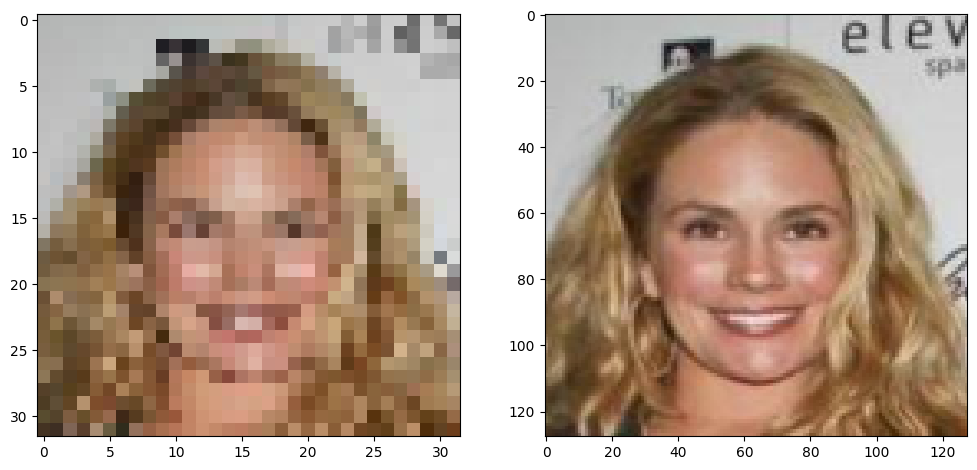

In [ ]:
#Scaling the images before plotting

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)
hr_images = hr_images.astype('float32')
hr_images /= 255.0
lr_images = lr_images.astype('float32')
lr_images /= 255.0


#Sanity check, view few mages
import random
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

Next, we split the dataset into train and test images to be set aside for training.

In [ ]:
#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

Putting everything together, we instantiate the generator, discriminator and the VGG with the proper inputs, combine them and compile the model with the loss functions: Binary crossentropy to measure the adverserial loss and MSE to measure the content loss, both summing up to make perceptual loss.

In [ ]:
#Instantiating the generator and the VGG model

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

The training process involves alternating between training the generator and the discriminator. In each iteration, the discriminator is trained on a batch of real HR images and a batch of generated fake images. The generator is then trained on a batch of LR images and their corresponding real HR images.

The loss function for the generator consists of two components: an adversarial loss and a content loss. The adversarial loss is based on the output of the discriminator, which provides feedback on the realism of the generated images. The content loss is based on the similarity of the generated HR images to the real HR images, as measured by a pre-trained VGG network.

The training is carried out for a specified number of epochs, with the generator being saved periodically. At the end of each epoch, the average generator and discriminator losses are calculated and reported.


In [ ]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1 
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
    
    
epochs = 15
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 5 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save('/content/drive/MyDrive/Model/gen_e_'+ str(e+1) +'.h5')


  0%|          | 0/3350 [00:00<?, ?it/s]

1/1 [==============================] - 0s 246ms/step


  0%|          | 1/3350 [00:44<40:56:29, 44.01s/it]

1/1 [==============================] - 0s 21ms/step


  0%|          | 2/3350 [00:44<16:55:55, 18.21s/it]

1/1 [==============================] - 0s 21ms/step


  0%|          | 3/3350 [00:44<9:15:28,  9.96s/it] 

1/1 [==============================] - 0s 20ms/step


  0%|          | 4/3350 [00:44<5:39:07,  6.08s/it]

1/1 [==============================] - 0s 21ms/step


  0%|          | 5/3350 [00:44<3:39:34,  3.94s/it]

1/1 [==============================] - 0s 20ms/step


  0%|          | 6/3350 [00:44<2:27:31,  2.65s/it]

1/1 [==============================] - 0s 20ms/step


  0%|          | 7/3350 [00:44<1:41:50,  1.83s/it]

1/1 [==============================] - 0s 20ms/step


  0%|          | 8/3350 [00:45<1:11:59,  1.29s/it]

1/1 [==============================] - 0s 19ms/step


  0%|          | 9/3350 [00:45<51:51,  1.07it/s]  

1/1 [==============================] - 0s 20ms/step


  0%|          | 10/3350 [00:45<38:13,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 11/3350 [00:45<28:55,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 12/3350 [00:45<22:29,  2.47it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 13/3350 [00:45<17:59,  3.09it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 14/3350 [00:45<14:51,  3.74it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 15/3350 [00:45<12:40,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 16/3350 [00:46<11:08,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 17/3350 [00:46<10:05,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 18/3350 [00:46<09:20,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 19/3350 [00:46<09:04,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 20/3350 [00:46<08:40,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 21/3350 [00:46<08:21,  6.64it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 22/3350 [00:46<08:08,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 23/3350 [00:47<08:06,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 24/3350 [00:47<08:01,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 25/3350 [00:47<07:52,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 26/3350 [00:47<07:47,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 27/3350 [00:47<07:48,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 28/3350 [00:47<07:53,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 29/3350 [00:47<07:50,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 30/3350 [00:48<07:45,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 31/3350 [00:48<07:43,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 32/3350 [00:48<07:39,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 33/3350 [00:48<07:39,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 34/3350 [00:48<07:39,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 35/3350 [00:48<07:45,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 36/3350 [00:48<07:42,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 37/3350 [00:49<07:42,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 38/3350 [00:49<07:40,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 39/3350 [00:49<07:39,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 40/3350 [00:49<07:37,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 41/3350 [00:49<07:39,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 42/3350 [00:49<07:38,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 43/3350 [00:49<07:42,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 44/3350 [00:50<07:43,  7.14it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 45/3350 [00:50<07:56,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 46/3350 [00:50<07:51,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 47/3350 [00:50<07:46,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 48/3350 [00:50<07:45,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 49/3350 [00:50<07:43,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 50/3350 [00:50<07:41,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 51/3350 [00:51<07:37,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 52/3350 [00:51<07:57,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 53/3350 [00:51<07:54,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 54/3350 [00:51<07:48,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 55/3350 [00:51<07:50,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 56/3350 [00:51<07:48,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 57/3350 [00:51<07:45,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 58/3350 [00:52<07:42,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 59/3350 [00:52<07:39,  7.16it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 60/3350 [00:52<07:47,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 61/3350 [00:52<07:50,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 62/3350 [00:52<07:49,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 63/3350 [00:52<07:48,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 64/3350 [00:52<07:46,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 65/3350 [00:53<07:49,  6.99it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 66/3350 [00:53<07:55,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 67/3350 [00:53<07:52,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 68/3350 [00:53<07:48,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 69/3350 [00:53<07:52,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 70/3350 [00:53<07:51,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 71/3350 [00:53<07:49,  6.98it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 72/3350 [00:54<07:53,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 73/3350 [00:54<07:50,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 74/3350 [00:54<07:48,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 75/3350 [00:54<07:46,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 76/3350 [00:54<07:45,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 77/3350 [00:54<07:59,  6.83it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 78/3350 [00:54<08:00,  6.81it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 79/3350 [00:55<08:01,  6.79it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 80/3350 [00:55<07:58,  6.83it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 81/3350 [00:55<07:54,  6.89it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 82/3350 [00:55<08:00,  6.80it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 83/3350 [00:55<07:56,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 84/3350 [00:55<07:51,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 85/3350 [00:55<07:48,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 86/3350 [00:56<07:53,  6.90it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 87/3350 [00:56<07:56,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 88/3350 [00:56<07:56,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 89/3350 [00:56<07:53,  6.88it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 90/3350 [00:56<07:57,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 91/3350 [00:56<07:52,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 92/3350 [00:56<07:52,  6.90it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 93/3350 [00:57<07:54,  6.86it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 94/3350 [00:57<08:00,  6.78it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 95/3350 [00:57<07:57,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 96/3350 [00:57<07:52,  6.88it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 97/3350 [00:57<07:53,  6.87it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 98/3350 [00:57<07:51,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 99/3350 [00:57<07:48,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 100/3350 [00:58<07:43,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 101/3350 [00:58<07:47,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 102/3350 [00:58<07:51,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 103/3350 [00:58<07:48,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 104/3350 [00:58<07:42,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 105/3350 [00:58<07:38,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 106/3350 [00:58<07:33,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 107/3350 [00:59<07:29,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 108/3350 [00:59<07:26,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 109/3350 [00:59<07:30,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 110/3350 [00:59<07:33,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 111/3350 [00:59<07:36,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 112/3350 [00:59<07:40,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 113/3350 [00:59<07:40,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 114/3350 [01:00<07:33,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 115/3350 [01:00<07:31,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 116/3350 [01:00<07:30,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 117/3350 [01:00<07:31,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 118/3350 [01:00<07:31,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 119/3350 [01:00<07:38,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 120/3350 [01:00<07:35,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 121/3350 [01:01<07:34,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 122/3350 [01:01<07:30,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 123/3350 [01:01<07:33,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 124/3350 [01:01<07:31,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 125/3350 [01:01<07:36,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 126/3350 [01:01<07:34,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 127/3350 [01:01<07:39,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 128/3350 [01:02<07:36,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 129/3350 [01:02<07:31,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 130/3350 [01:02<07:28,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 131/3350 [01:02<07:30,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 132/3350 [01:02<07:29,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 133/3350 [01:02<07:30,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 134/3350 [01:02<07:30,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 135/3350 [01:02<07:25,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 136/3350 [01:03<07:28,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 137/3350 [01:03<07:28,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 138/3350 [01:03<07:28,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 139/3350 [01:03<07:26,  7.19it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 140/3350 [01:03<07:29,  7.15it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 141/3350 [01:03<07:39,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 142/3350 [01:03<07:33,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 143/3350 [01:04<07:29,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 144/3350 [01:04<07:32,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 145/3350 [01:04<07:33,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 146/3350 [01:04<07:31,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 147/3350 [01:04<07:31,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 148/3350 [01:04<07:33,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 149/3350 [01:04<07:33,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 150/3350 [01:05<07:29,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 151/3350 [01:05<07:27,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 152/3350 [01:05<07:37,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 153/3350 [01:05<07:36,  7.01it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 154/3350 [01:05<07:41,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 155/3350 [01:05<07:36,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 156/3350 [01:05<07:31,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 157/3350 [01:06<07:27,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 158/3350 [01:06<07:24,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 159/3350 [01:06<07:20,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 160/3350 [01:06<07:18,  7.28it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 161/3350 [01:06<07:24,  7.17it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 162/3350 [01:06<07:37,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 163/3350 [01:06<07:39,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 164/3350 [01:07<07:35,  6.99it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 165/3350 [01:07<07:34,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 166/3350 [01:07<07:29,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 167/3350 [01:07<07:40,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 168/3350 [01:07<07:36,  6.98it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 169/3350 [01:07<07:41,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 170/3350 [01:07<07:40,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 171/3350 [01:08<07:35,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 172/3350 [01:08<07:33,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 173/3350 [01:08<07:35,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 174/3350 [01:08<07:33,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 175/3350 [01:08<07:34,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 176/3350 [01:08<07:32,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 177/3350 [01:08<07:39,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 178/3350 [01:09<07:45,  6.81it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 179/3350 [01:09<07:44,  6.83it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 180/3350 [01:09<07:43,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 181/3350 [01:09<07:41,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 182/3350 [01:09<07:35,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 183/3350 [01:09<07:33,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 184/3350 [01:09<07:32,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 185/3350 [01:10<07:32,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 186/3350 [01:10<07:35,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 187/3350 [01:10<07:33,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 188/3350 [01:10<07:45,  6.80it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 189/3350 [01:10<07:40,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 190/3350 [01:10<07:33,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 191/3350 [01:10<07:31,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 192/3350 [01:11<07:28,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 193/3350 [01:11<07:25,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 194/3350 [01:11<07:29,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 195/3350 [01:11<07:39,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 196/3350 [01:11<07:35,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 197/3350 [01:11<07:31,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 198/3350 [01:11<07:29,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 199/3350 [01:12<07:26,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 200/3350 [01:12<07:22,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 201/3350 [01:12<07:21,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 202/3350 [01:12<07:20,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 203/3350 [01:12<07:25,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 204/3350 [01:12<07:25,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 205/3350 [01:12<07:24,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 206/3350 [01:13<07:22,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 207/3350 [01:13<07:21,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 208/3350 [01:13<07:20,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 209/3350 [01:13<07:32,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 210/3350 [01:13<07:37,  6.87it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 211/3350 [01:13<07:35,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 212/3350 [01:13<07:29,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 213/3350 [01:14<07:24,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 214/3350 [01:14<07:19,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 215/3350 [01:14<07:19,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 216/3350 [01:14<07:17,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 217/3350 [01:14<07:14,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 218/3350 [01:14<07:15,  7.19it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 219/3350 [01:14<07:25,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 220/3350 [01:15<07:24,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 221/3350 [01:15<07:24,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 222/3350 [01:15<07:22,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 223/3350 [01:15<07:22,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 224/3350 [01:15<07:20,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 225/3350 [01:15<07:20,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 226/3350 [01:15<07:18,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 227/3350 [01:16<07:14,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 228/3350 [01:16<07:19,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 229/3350 [01:16<07:18,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 230/3350 [01:16<07:15,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 231/3350 [01:16<07:13,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 232/3350 [01:16<07:13,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 233/3350 [01:16<07:14,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 234/3350 [01:17<07:14,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 235/3350 [01:17<07:14,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 236/3350 [01:17<07:20,  7.08it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 237/3350 [01:17<07:23,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 238/3350 [01:17<07:22,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 239/3350 [01:17<07:23,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 240/3350 [01:17<07:17,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 241/3350 [01:18<07:15,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 242/3350 [01:18<07:14,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 243/3350 [01:18<07:12,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 244/3350 [01:18<07:11,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 245/3350 [01:18<07:16,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 246/3350 [01:18<07:19,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 247/3350 [01:18<07:16,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 248/3350 [01:19<07:13,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 249/3350 [01:19<07:15,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 250/3350 [01:19<07:12,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 251/3350 [01:19<07:10,  7.19it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 252/3350 [01:19<07:25,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 253/3350 [01:19<07:28,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 254/3350 [01:19<07:24,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 255/3350 [01:20<07:22,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 256/3350 [01:20<07:20,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 257/3350 [01:20<07:17,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 258/3350 [01:20<07:16,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 259/3350 [01:20<07:13,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 260/3350 [01:20<07:17,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 261/3350 [01:20<07:14,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 262/3350 [01:21<07:20,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 263/3350 [01:21<07:20,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 264/3350 [01:21<07:18,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 265/3350 [01:21<07:15,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 266/3350 [01:21<07:17,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 267/3350 [01:21<07:15,  7.08it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 268/3350 [01:21<07:25,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 269/3350 [01:22<07:22,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 270/3350 [01:22<07:26,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 271/3350 [01:22<07:22,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 272/3350 [01:22<07:17,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 273/3350 [01:22<07:14,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 274/3350 [01:22<07:09,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 275/3350 [01:22<07:08,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 276/3350 [01:22<07:04,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 277/3350 [01:23<07:05,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 278/3350 [01:23<07:04,  7.23it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 279/3350 [01:23<07:18,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 280/3350 [01:23<07:18,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 281/3350 [01:23<07:17,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 282/3350 [01:23<07:16,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 283/3350 [01:23<07:09,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 284/3350 [01:24<07:05,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 285/3350 [01:24<07:04,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 286/3350 [01:24<07:01,  7.26it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 287/3350 [01:24<07:06,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 288/3350 [01:24<07:07,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 289/3350 [01:24<07:07,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 290/3350 [01:24<07:11,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 291/3350 [01:25<07:07,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 292/3350 [01:25<07:14,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 293/3350 [01:25<07:12,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 294/3350 [01:25<07:24,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 295/3350 [01:25<07:25,  6.86it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 296/3350 [01:25<07:22,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 297/3350 [01:25<07:23,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 298/3350 [01:26<07:17,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 299/3350 [01:26<07:14,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 300/3350 [01:26<07:10,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 301/3350 [01:26<07:14,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 302/3350 [01:26<07:14,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 303/3350 [01:26<07:14,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 304/3350 [01:26<07:18,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 305/3350 [01:27<07:15,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 306/3350 [01:27<07:15,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 307/3350 [01:27<07:21,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 308/3350 [01:27<07:17,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 309/3350 [01:27<07:14,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 310/3350 [01:27<07:11,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 311/3350 [01:27<07:19,  6.91it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 312/3350 [01:28<07:21,  6.89it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 313/3350 [01:28<07:18,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 314/3350 [01:28<07:14,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 315/3350 [01:28<07:10,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 316/3350 [01:28<07:13,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 317/3350 [01:28<07:12,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 318/3350 [01:28<07:08,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 319/3350 [01:29<07:03,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 320/3350 [01:29<07:01,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 321/3350 [01:29<07:12,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 322/3350 [01:29<07:10,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 323/3350 [01:29<07:09,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 324/3350 [01:29<07:06,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 325/3350 [01:29<07:02,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 326/3350 [01:30<07:05,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 327/3350 [01:30<07:02,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 328/3350 [01:30<07:00,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 329/3350 [01:30<07:03,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 330/3350 [01:30<07:02,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 331/3350 [01:30<06:58,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 332/3350 [01:30<06:57,  7.22it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 333/3350 [01:31<07:08,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 334/3350 [01:31<07:03,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 335/3350 [01:31<07:00,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 336/3350 [01:31<06:57,  7.22it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 337/3350 [01:31<07:04,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 338/3350 [01:31<07:03,  7.12it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 339/3350 [01:31<07:05,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 340/3350 [01:32<07:12,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 341/3350 [01:32<07:09,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 342/3350 [01:32<07:11,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 343/3350 [01:32<07:06,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 344/3350 [01:32<07:01,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 345/3350 [01:32<07:04,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 346/3350 [01:32<07:09,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 347/3350 [01:33<07:09,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 348/3350 [01:33<07:08,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 349/3350 [01:33<07:06,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 350/3350 [01:33<07:02,  7.10it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 351/3350 [01:33<07:03,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 352/3350 [01:33<07:03,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 353/3350 [01:33<07:04,  7.06it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 354/3350 [01:34<07:08,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 355/3350 [01:34<07:08,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 356/3350 [01:34<07:06,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 357/3350 [01:34<07:02,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 358/3350 [01:34<07:05,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 359/3350 [01:34<07:04,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 360/3350 [01:34<07:03,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 361/3350 [01:35<07:03,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 362/3350 [01:35<06:57,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 363/3350 [01:35<07:01,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 364/3350 [01:35<07:00,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 365/3350 [01:35<06:59,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 366/3350 [01:35<06:56,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 367/3350 [01:35<06:54,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 368/3350 [01:36<06:53,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 369/3350 [01:36<06:53,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 370/3350 [01:36<06:50,  7.25it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 371/3350 [01:36<06:54,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 372/3350 [01:36<06:53,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 373/3350 [01:36<06:52,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 374/3350 [01:36<06:50,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 375/3350 [01:36<06:51,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 376/3350 [01:37<06:49,  7.25it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 377/3350 [01:37<06:52,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 378/3350 [01:37<06:52,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 379/3350 [01:37<06:56,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 380/3350 [01:37<06:55,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 381/3350 [01:37<06:55,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 382/3350 [01:37<06:53,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 383/3350 [01:38<06:51,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 384/3350 [01:38<06:59,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 385/3350 [01:38<06:56,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 386/3350 [01:38<06:53,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 387/3350 [01:38<06:57,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 388/3350 [01:38<06:57,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 389/3350 [01:38<06:59,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 390/3350 [01:39<06:56,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 391/3350 [01:39<06:59,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 392/3350 [01:39<06:56,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 393/3350 [01:39<06:53,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 394/3350 [01:39<06:51,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 395/3350 [01:39<06:52,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 396/3350 [01:39<07:00,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 397/3350 [01:40<07:00,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 398/3350 [01:40<06:58,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 399/3350 [01:40<07:01,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 400/3350 [01:40<06:57,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 401/3350 [01:40<06:55,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 402/3350 [01:40<06:53,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 403/3350 [01:40<06:52,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 404/3350 [01:41<06:55,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 405/3350 [01:41<06:55,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 406/3350 [01:41<06:54,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 407/3350 [01:41<06:52,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 408/3350 [01:41<06:52,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 409/3350 [01:41<06:56,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 410/3350 [01:41<06:56,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 411/3350 [01:42<06:57,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 412/3350 [01:42<06:59,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 413/3350 [01:42<07:04,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 414/3350 [01:42<07:02,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 415/3350 [01:42<07:03,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 416/3350 [01:42<07:00,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 417/3350 [01:42<06:56,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 418/3350 [01:43<06:54,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 419/3350 [01:43<06:54,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 420/3350 [01:43<06:54,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 421/3350 [01:43<06:57,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 422/3350 [01:43<06:58,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 423/3350 [01:43<06:58,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 424/3350 [01:43<06:55,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 425/3350 [01:44<06:54,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 426/3350 [01:44<06:55,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 427/3350 [01:44<06:52,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 428/3350 [01:44<06:50,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 429/3350 [01:44<06:54,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 430/3350 [01:44<06:56,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 431/3350 [01:44<06:54,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 432/3350 [01:45<06:59,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 433/3350 [01:45<07:01,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 434/3350 [01:45<06:59,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 435/3350 [01:45<06:58,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 436/3350 [01:45<06:52,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 437/3350 [01:45<06:51,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 438/3350 [01:45<07:00,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 439/3350 [01:46<06:58,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 440/3350 [01:46<06:57,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 441/3350 [01:46<06:51,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 442/3350 [01:46<06:55,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 443/3350 [01:46<06:57,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 444/3350 [01:46<06:54,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 445/3350 [01:46<06:50,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 446/3350 [01:47<06:56,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 447/3350 [01:47<06:58,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 448/3350 [01:47<07:00,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 449/3350 [01:47<07:01,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 450/3350 [01:47<07:00,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 451/3350 [01:47<06:58,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 452/3350 [01:47<06:53,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 453/3350 [01:48<06:48,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 454/3350 [01:48<06:46,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 455/3350 [01:48<06:49,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 456/3350 [01:48<06:56,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 457/3350 [01:48<06:54,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 458/3350 [01:48<06:50,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 459/3350 [01:48<06:46,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 460/3350 [01:49<06:45,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 461/3350 [01:49<06:44,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 462/3350 [01:49<06:45,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 463/3350 [01:49<06:49,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 464/3350 [01:49<06:50,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 465/3350 [01:49<06:48,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 466/3350 [01:49<06:50,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 467/3350 [01:50<06:46,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 468/3350 [01:50<06:44,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 469/3350 [01:50<06:45,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 470/3350 [01:50<06:46,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 471/3350 [01:50<06:49,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 472/3350 [01:50<06:52,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 473/3350 [01:50<06:48,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 474/3350 [01:51<06:46,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 475/3350 [01:51<06:42,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 476/3350 [01:51<06:40,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 477/3350 [01:51<06:39,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 478/3350 [01:51<06:50,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 479/3350 [01:51<06:51,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 480/3350 [01:51<06:52,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 481/3350 [01:52<06:49,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 482/3350 [01:52<06:46,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 483/3350 [01:52<06:47,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 484/3350 [01:52<06:50,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 485/3350 [01:52<07:01,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 486/3350 [01:52<06:53,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 487/3350 [01:52<06:49,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 488/3350 [01:53<06:47,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 489/3350 [01:53<06:44,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 490/3350 [01:53<06:44,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 491/3350 [01:53<06:41,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 492/3350 [01:53<06:41,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 493/3350 [01:53<06:40,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 494/3350 [01:53<06:38,  7.17it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 495/3350 [01:53<06:38,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 496/3350 [01:54<06:40,  7.13it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 497/3350 [01:54<06:44,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 498/3350 [01:54<06:47,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 499/3350 [01:54<06:54,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 500/3350 [01:54<06:52,  6.91it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 501/3350 [01:54<06:49,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 502/3350 [01:54<06:43,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 503/3350 [01:55<06:42,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 504/3350 [01:55<06:39,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 505/3350 [01:55<06:44,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 506/3350 [01:55<06:44,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 507/3350 [01:55<06:43,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 508/3350 [01:55<06:40,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 509/3350 [01:55<06:39,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 510/3350 [01:56<06:36,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 511/3350 [01:56<06:37,  7.14it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 512/3350 [01:56<06:41,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 513/3350 [01:56<06:44,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 514/3350 [01:56<06:43,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 515/3350 [01:56<06:43,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 516/3350 [01:56<06:39,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 517/3350 [01:57<06:40,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 518/3350 [01:57<06:43,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 519/3350 [01:57<06:42,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 520/3350 [01:57<06:39,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 521/3350 [01:57<06:48,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 522/3350 [01:57<06:47,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 523/3350 [01:57<06:48,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 524/3350 [01:58<06:53,  6.83it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 525/3350 [01:58<06:53,  6.83it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 526/3350 [01:58<06:50,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 527/3350 [01:58<06:57,  6.76it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 528/3350 [01:58<06:59,  6.72it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 529/3350 [01:58<06:57,  6.75it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 530/3350 [01:59<06:58,  6.74it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 531/3350 [01:59<06:55,  6.79it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 532/3350 [01:59<06:55,  6.78it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 533/3350 [01:59<07:11,  6.53it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 534/3350 [01:59<07:04,  6.63it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 535/3350 [01:59<07:01,  6.67it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 536/3350 [01:59<06:57,  6.74it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 537/3350 [02:00<06:50,  6.86it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 538/3350 [02:00<06:54,  6.78it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 539/3350 [02:00<06:54,  6.77it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 540/3350 [02:00<06:52,  6.80it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 541/3350 [02:00<06:51,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 542/3350 [02:00<06:46,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 543/3350 [02:00<06:42,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 544/3350 [02:01<06:40,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 545/3350 [02:01<06:39,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 546/3350 [02:01<06:42,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 547/3350 [02:01<06:42,  6.96it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 548/3350 [02:01<06:47,  6.88it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 549/3350 [02:01<06:46,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 550/3350 [02:01<06:42,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 551/3350 [02:02<06:39,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 552/3350 [02:02<06:38,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 553/3350 [02:02<06:35,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 554/3350 [02:02<06:35,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 555/3350 [02:02<06:39,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 556/3350 [02:02<06:40,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 557/3350 [02:02<06:41,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 558/3350 [02:03<06:36,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 559/3350 [02:03<06:35,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 560/3350 [02:03<06:38,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 561/3350 [02:03<06:40,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 562/3350 [02:03<06:39,  6.99it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 563/3350 [02:03<06:54,  6.72it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 564/3350 [02:03<06:50,  6.79it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 565/3350 [02:04<06:44,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 566/3350 [02:04<06:41,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 567/3350 [02:04<06:36,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 568/3350 [02:04<06:37,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 569/3350 [02:04<06:39,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 570/3350 [02:04<06:38,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 571/3350 [02:04<06:41,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 572/3350 [02:05<06:38,  6.96it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 573/3350 [02:05<06:38,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 574/3350 [02:05<06:38,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 575/3350 [02:05<06:36,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 576/3350 [02:05<06:37,  6.98it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 577/3350 [02:05<06:42,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 578/3350 [02:05<06:40,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 579/3350 [02:06<06:42,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 580/3350 [02:06<06:47,  6.80it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 581/3350 [02:06<06:49,  6.76it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 582/3350 [02:06<06:47,  6.79it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 583/3350 [02:06<06:56,  6.64it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 584/3350 [02:06<06:59,  6.59it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 585/3350 [02:07<07:01,  6.56it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 586/3350 [02:07<07:00,  6.57it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 587/3350 [02:07<06:53,  6.68it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 588/3350 [02:07<07:00,  6.58it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 589/3350 [02:07<07:16,  6.33it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 590/3350 [02:07<07:10,  6.41it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 591/3350 [02:07<07:07,  6.45it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 592/3350 [02:08<07:11,  6.39it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 593/3350 [02:08<07:01,  6.54it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 594/3350 [02:08<06:59,  6.56it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 595/3350 [02:08<09:55,  4.62it/s]


KeyboardInterrupt: ignored

Finally, we test the model after training. These are the results we achieved.

1/1 [==============================] - 1s 710ms/step


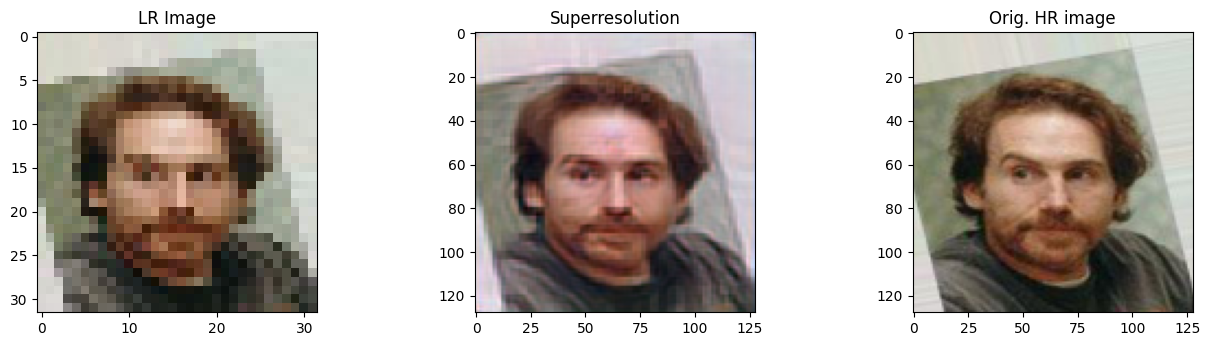

In [ ]:
###################################################################################
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model("/content/drive/My Drive/Model/gen_e_15.h5", compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()



#### Evaluation Metrics
We used two metrics to evaluate the performance of the SRGAN model: adversarial loss and content loss. Adversarial loss measures the difference between the generated image and the real image using binary crossentropy, while content loss measures the difference between the feature maps generated by VGG19 for the generated image and the real image using mean squared error (MSE).

#### Results
The SRGAN model produced impressive results on the CelebA dataset, achieving an adversarial loss of 0.08 and a content loss of 0.93. These metrics indicate that the generated images are of good quality and resemble the original images. Visually, the generated images are clear enough and have recovered more detail than the low-resolution images.

#### Conclusion
In conclusion, the implemented SRGAN model has performed very well on the CelebA dataset, achieving low adversarial loss and content loss scores. These results indicate that the SRGAN model is an effective approach for single-image super-resolution, and has the potential to be used in a variety of applications where high-resolution images are required.

#### Limitations

During the implementation of the SRGAN and VAE models, we faced several challenges that affected the progress of the project. One of the main challenges was the size of the images in the dataset, which often exceeded the RAM limitations of the machine. This led to frequent memory errors and required us to optimize the loading and processing of the images. Additionally, the long training times required to train the SRGAN and VAE models proved to be a significant challenge. The sessions often crashed due to a lack of memory or GPU resources, which resulted in the loss of valuable training progress. We also faced difficulties in debugging and fine-tuning the model due to the complex nature of the deep learning architecture.

#### Recommendations

Based on the results,  We would recommend the following:

1. Upgrade existing CCTV cameras with high-resolution cameras: While the SRGAN model can enhance low-resolution images to a certain extent, it is still limited by the quality of the original images. Therefore, upgrading existing CCTV cameras with high-resolution cameras would provide better input images for the SRGAN model to work with, resulting in even better super-resolved images.

2. Deploy SRGAN models on-site or in the cloud: Depending on the size of the CCTV network, it may be more efficient to deploy the SRGAN model on-site or in the cloud. This would allow for faster processing of the images and quicker access to the super-resolved images. Additionally, deploying the model in the cloud would allow for scalability and ease of maintenance.

3. Combine SRGAN with object detection algorithms: Object detection algorithms can be used to identify specific objects or people in the super-resolved images. This would improve the accuracy and effectiveness of the CCTV system in identifying potential security threats.

4. Train staff on interpreting super-resolved images: Super-resolved images may contain more detail and information than the original images, which could potentially aid in investigations. Therefore, it is important to train staff on how to interpret and analyze these images effectively.

5. Consider privacy and ethical concerns: While the SRGAN model can enhance images for security purposes, it is important to consider privacy and ethical concerns. Law enforcement agencies should ensure that they have policies and procedures in place to protect the privacy of individuals and to use the technology ethically and responsibly.